In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet

from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.ensemble import RandomForestRegressor

In [60]:
plt.rcParams.update({'figure.figsize':(18,10), 'figure.dpi':120})

# function to plot results
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

# function to calc RMSE and R^2; and also plot results
def eval_results(y, yhat, y_scaler = None, plot=True):
    if y_scaler != None:
        yhat = y_scaler.inverse_transform(np.array(yhat).reshape(-1,1)).flatten()
        
    print("RMSE: ", mean_squared_error(y, yhat, squared = False))
    print("R^2: ", r2_score(y, yhat))

    if plot:
        plt.figure(figsize = (20,10))
        plot_series(np.arange(len(y)), y)
        plot_series(np.arange(len(yhat)), yhat)

In [61]:
df = pd.read_csv(r'HourlyElectricityLoad.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)
df.drop_duplicates(subset=["dt"], keep='first', inplace=True)

In [62]:
def add_datepart(df1, fldname):
    fld = df1[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df1[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    for n in ('Dayofweek', 
            'Dayofyear'):
        df1[n] = getattr(fld.dt,n.lower())

In [63]:
split_time = len(df)-168

df_prophet = df[:split_time]
df_prophet.columns=["ds","y"]

#series['y'] = series['y'].astype(float)
m = Prophet()
m.fit(df_prophet)

13:50:06 - cmdstanpy - INFO - Chain [1] start processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = m.make_future_dataframe(periods=168, freq='H')

prophet_forecast = m.predict(future)

In [98]:
add_datepart(df, "dt" )
df["resid"] = df.Load.values - prophet_forecast.yhat.values

In [99]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if (type(data) is list or len(data.shape) == 1) else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg, names[:n_vars*n_in], names[n_vars*n_in:]

In [108]:
data, features, targets = series_to_supervised(df.resid, n_in=24, n_out=1, dropnan=True)
data["Dayofyear"] = df.Dayofyear
data["Dayofweek"] = df.Dayofweek

features += ["Dayofyear", "Dayofweek"]
split = len(data)-168
X_train = data[:split][features]
y_train = data[:split][targets]

X_val = data[split:][features]
y_val = data[split:][targets]
#X_val.tail(28)

In [103]:


splits = TimeSeriesSplit(n_splits=3, max_train_size=365*5*24)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [10, 20, 30], 
        'max_features': [16, 22, 26],#'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["var1(t)"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 30}
Best-Fold Train RMSE:  584.0210531495457
Best-Fold Val RMSE:  4960.491247213553


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 30}
Best-Fold Train RMSE:  557.9951116102455
Best-Fold Val RMSE:  5029.461914272168


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 22, 'max_depth': 30}
Best-Fold Train RMSE:  544.352855625679
Best-Fold Val RMSE:  5061.120732368101




In [104]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train, y_train["var1(t)"])

In [118]:
X_f = np.array(X_val.iloc[0]).reshape(1,-1)
forecast = []


for i in range(1,169):
    pred = best_rfr.predict(X_f)
    forecast.append(pred)
    if i != 168:
        X_f = np.concatenate([X_f[:,1:-2],np.array([pred]), np.array(X_val.iloc[i][-2:]).reshape(1,-1)],1)

/Users/andreypak/opt/miniconda3/envs/electro/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/andreypak/opt/miniconda3/envs/electro/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/andreypak/opt/miniconda3/envs/electro/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/andreypak/opt/miniconda3/envs/electro/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/andreypak/opt/miniconda3/envs/electro/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have vali

RMSE:  331.81978994112416
R^2:  0.3999164222706738


/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_17393/1699576406.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  raw_valid = df['Load'][split_time:]
/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_17393/3624077533.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format)


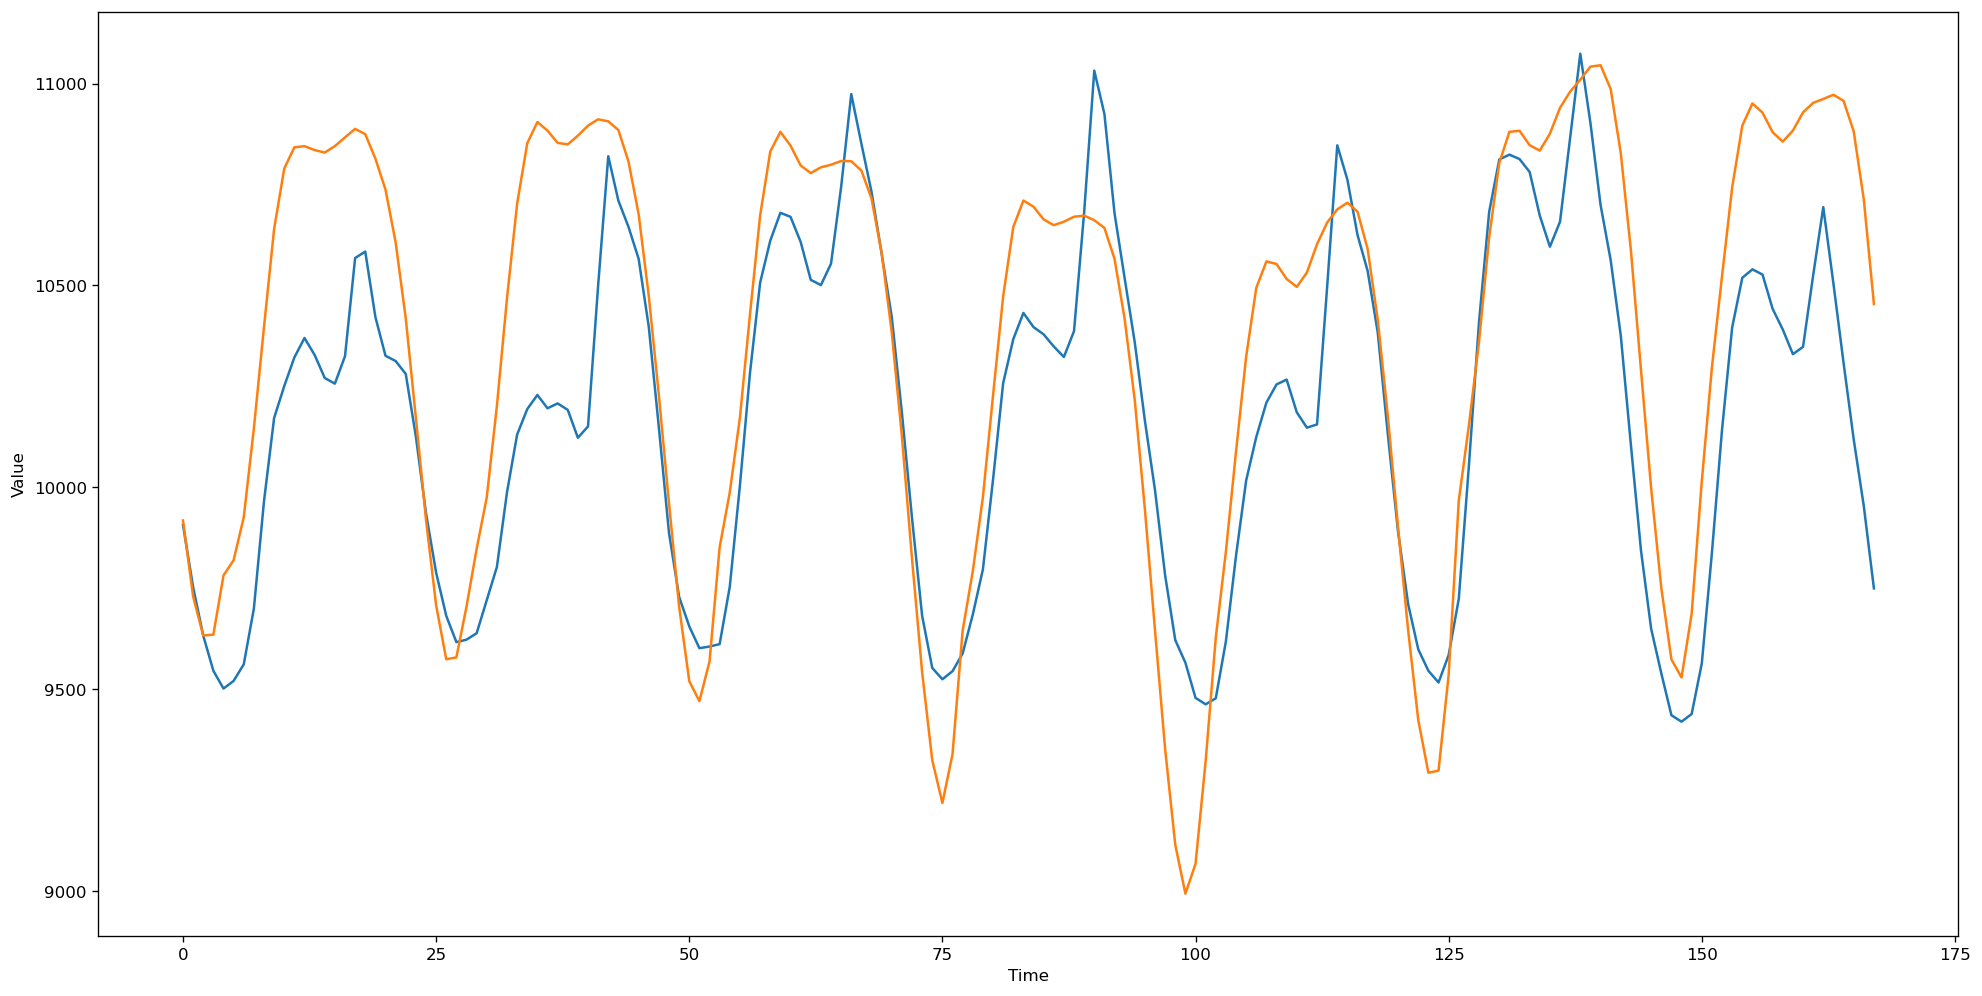

In [119]:
raw_valid = df['Load'][split_time:]
res = np.array(forecast).flatten()

res = res+prophet_forecast.yhat[-168:]
eval_results(raw_valid, res)

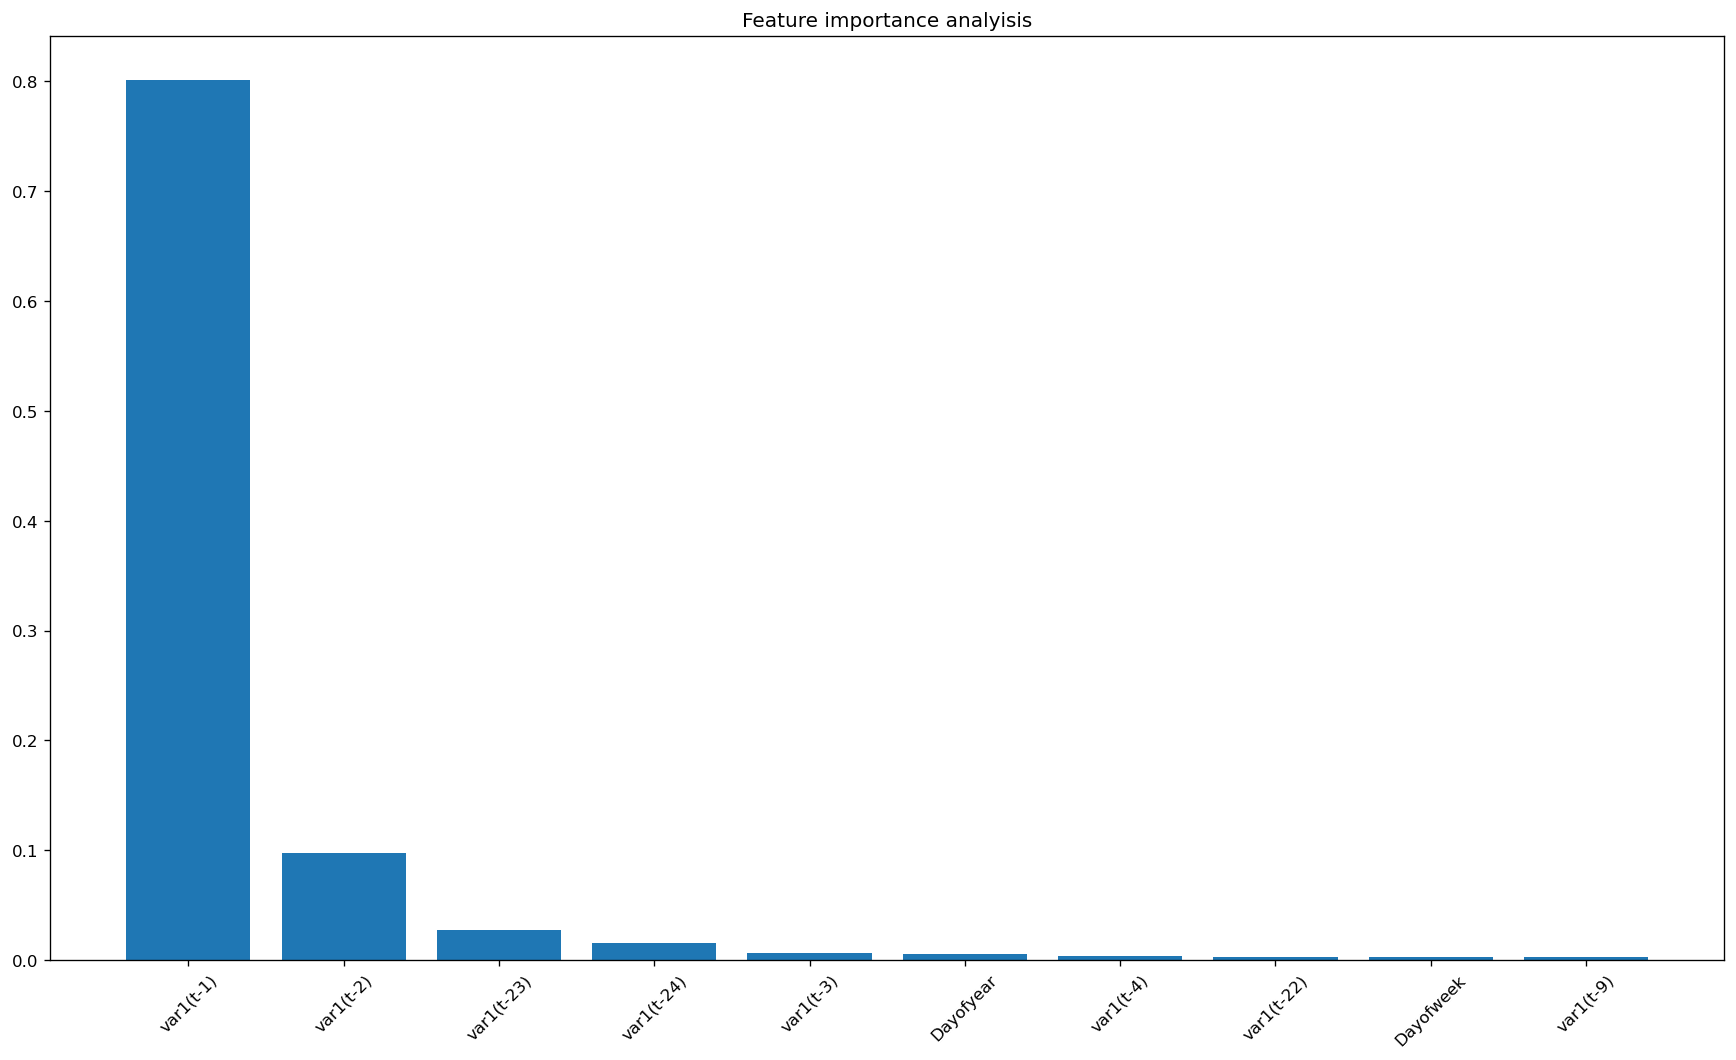

In [122]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()